# CDC Weekly Mortality Data for 121 Cities 1962-2016

### Importing Data

The CDC dataset used here provides the total number of weekly deaths in 121 US cities from 1962-2016.  It also provides the age breakdown of weekly deaths, as well as deaths due to flu and pnumonia.  

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context
df=pd.read_csv('https://data.cdc.gov/api/views/mr8w-325u/rows.csv?accessType=DOWNLOAD',index_col='Week Ending Date',parse_dates=True)

In [227]:
df.head()   

,Year,WEEK,REGION,State,City,Pneumonia and Influenza Deaths,All Deaths,<1 year (all cause deaths),1-24 years (all cause deaths),25-44 years,45-64 years (all cause deaths),65+ years (all cause deaths)
Week Ending Date,,,,,,,,,,,,
1962-01-06,1962,1,1,MA,Boston,11.0,262.0,10.0,8.0,11.0,87.0,146.0
1962-01-13,1962,2,1,MA,Boston,11.0,270.0,14.0,8.0,11.0,70.0,167.0
1962-01-20,1962,3,1,MA,Boston,5.0,237.0,11.0,8.0,10.0,66.0,142.0
1962-01-27,1962,4,1,MA,Boston,12.0,285.0,22.0,7.0,8.0,73.0,175.0
1962-02-03,1962,5,1,MA,Boston,5.0,245.0,15.0,9.0,17.0,62.0,142.0


We are only interested in the State, City and All Deaths Columns

In [228]:
df=df.drop(columns=['Year', 'WEEK', 'REGION',
       'Pneumonia and Influenza Deaths',
       '<1 year (all cause deaths)', '1-24 years (all cause deaths)',
       '25-44 years', '45-64 years (all cause deaths)',
       '65+ years (all cause deaths)'])

In [229]:
df.head()

,State,City,All Deaths
Week Ending Date,,,
1962-01-06,MA,Boston,262.0
1962-01-13,MA,Boston,270.0
1962-01-20,MA,Boston,237.0
1962-01-27,MA,Boston,285.0
1962-02-03,MA,Boston,245.0


In [230]:
df.tail()

,State,City,All Deaths
Week Ending Date,,,
2016-09-03,WA,Tacoma,136.0
2016-09-10,WA,Tacoma,136.0
2016-09-17,WA,Tacoma,129.0
2016-09-24,WA,Tacoma,143.0
2016-10-01,WA,Tacoma,136.0


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 346342 entries, 1962-01-06 to 2016-10-01
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   State       340300 non-null  object 
 1   City        340300 non-null  object 
 2   All Deaths  344871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.6+ MB


### Dealing with Missing Values 

In [232]:
df.loc[(df['City'].isnull()==True) & df['State'].isnull()==True].shape

(6042, 3)

In [233]:
df.loc[(df['City'].isnull()==True)].shape

(6042, 3)

In [234]:
df.loc[df['State'].isnull()==True].shape

(6042, 3)

In [235]:
df.loc[df['All Deaths'].isnull()==True].City.unique()

array(['Boston', 'Hartford', 'Bridgeport', 'Allentown', 'Cambridge',
       'Fall River', 'Yonkers', 'South Bend', 'Youngstown', 'Des Moines',
       'Kansas City', 'Lincoln', 'Lynn', 'New Bedford', 'Providence',
       'Somerville', 'Springfield', 'Waterbury', 'Worcester', 'Buffalo',
       'Camden', 'Elizabeth', 'Jersey City', 'New York', 'Newark',
       'Paterson', 'Philadelphia', 'Reading', 'Schenectady', 'Scranton',
       'Syracuse', 'Trenton', 'Utica', nan, 'Chicago', 'Cincinnati',
       'Cleveland', 'Columbus', 'Detroit', 'Evansville', 'Fort Wayne',
       'Gary', 'Indianapolis', 'Milwaukee', 'Peoria', 'Rockford',
       'Toledo', 'Duluth', 'Minneapolis', 'Saint Louis', 'Saint Paul',
       'Atlanta', 'Wichita', 'Wilimington', 'Charlotte', 'Birmingham',
       'Baton Rouge', 'Corpus Christi', 'New Orleans', 'Jacksonville',
       'Miami', 'Norfolk', 'Richmond', 'Saint Petersburg', 'Washington',
       'Chattanooga', 'Knoxville', 'Lexington', 'Memphis', 'Mobile',
       'Montg

In [236]:
len(df.loc[df['All Deaths'].isnull()==True].City.unique())

102

102 Cities have missing values for All Deaths.  We should investigate how these missing values are distributed, but it is safe delete the entries with missing state and city values.

In [237]:
df=df.dropna(subset=['State','City'],axis=0)

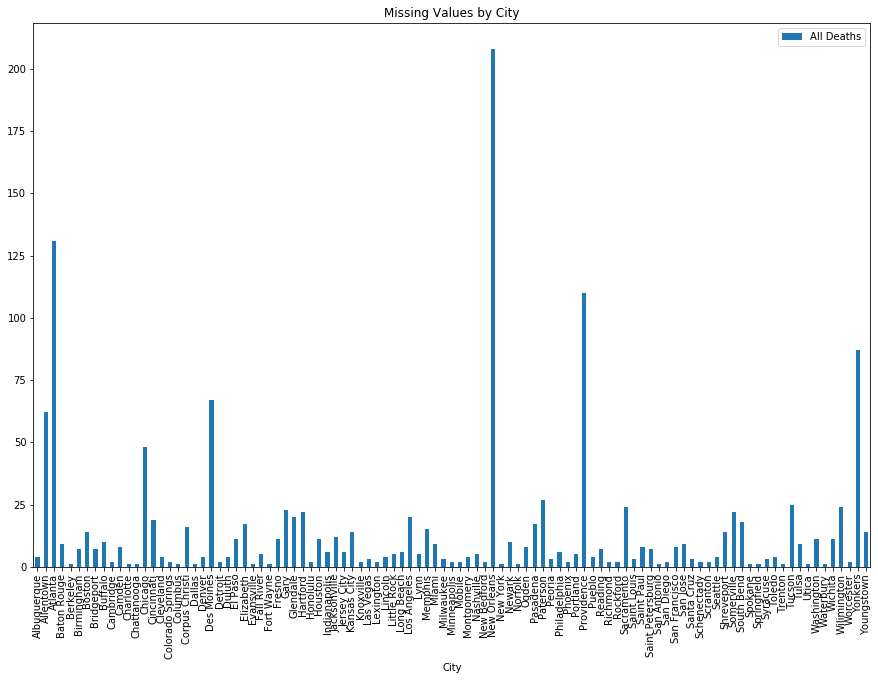

In [238]:
df.loc[df['All Deaths'].isnull()==True].fillna(1).groupby('City').sum().plot(kind='bar')
plt.title('Missing Values by City')
plt.show()

It is clear that some cities have a large number of missing values in their respective datasets.

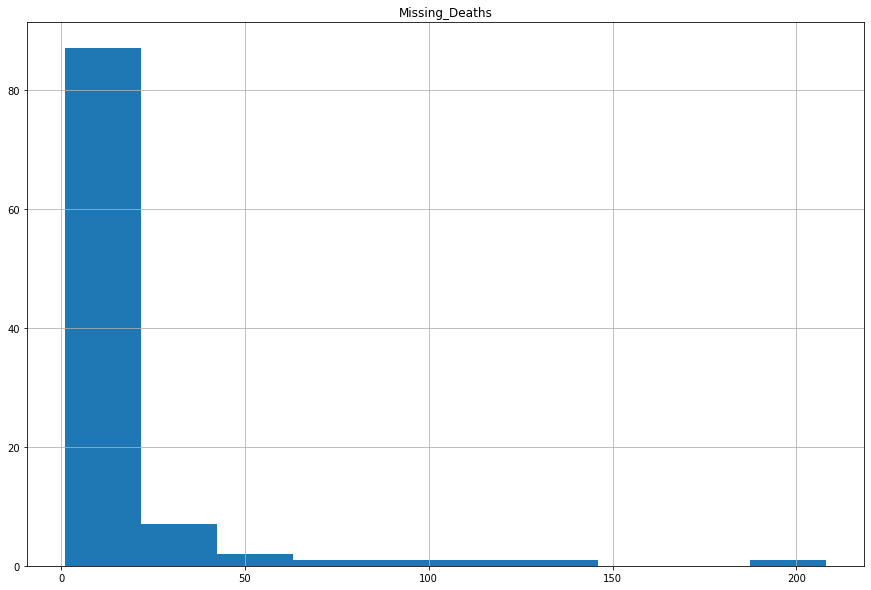

In [239]:
missing=pd.DataFrame(df.loc[df['All Deaths'].isnull()==True].fillna(1).groupby('City').sum())
missing.columns=['Missing_Deaths']
missing.hist()
plt.show()

The vast majority of cities have fewer than 50 missing values.  I will drop the outlier cities that are more than three standard deviations from the mean.  

In [240]:
s=missing.Missing_Deaths.std()
x_bar=missing.Missing_Deaths.mean()
upper,lower = x_bar + 3*s, x_bar - 3*s
missing=missing[(missing['Missing_Deaths']<upper)&(missing['Missing_Deaths']>lower)]

In [241]:
cities_final=missing.index

In [242]:
df=pd.DataFrame(df.loc[df['City'].isin(cities_final)])

In [243]:
df.isnull().sum()

State           0
City            0
All Deaths    962
dtype: int64

In [244]:
df.City.unique()

array(['Boston', 'Hartford', 'Bridgeport', 'Cambridge', 'Somerville',
       'Allentown', 'Fall River', 'Camden', 'Yonkers', 'Gary',
       'South Bend', 'Youngstown', 'Des Moines', 'Kansas City', 'Lincoln',
       'Lynn', 'New Bedford', 'Springfield', 'Waterbury', 'Worcester',
       'Buffalo', 'Elizabeth', 'Jersey City', 'New York', 'Newark',
       'Paterson', 'Philadelphia', 'Reading', 'Schenectady', 'Scranton',
       'Syracuse', 'Trenton', 'Utica', 'Chicago', 'Cincinnati',
       'Cleveland', 'Columbus', 'Detroit', 'Evansville', 'Fort Wayne',
       'Indianapolis', 'Milwaukee', 'Peoria', 'Rockford', 'Toledo',
       'Duluth', 'Minneapolis', 'Saint Louis', 'Saint Paul', 'Wichita',
       'Wilimington', 'Charlotte', 'Jacksonville', 'Birmingham',
       'Baton Rouge', 'Corpus Christi', 'Miami', 'Norfolk', 'Richmond',
       'Saint Petersburg', 'Washington', 'Chattanooga', 'Knoxville',
       'Lexington', 'Memphis', 'Mobile', 'Montgomery', 'Nashville',
       'Dallas', 'El Paso', 'Ho

We will fill each missing value left over with the average number of deaths with respect to each city

In [245]:
city_list=list(df.City.unique())
df_list=[]
for i in range(len(city_list)):
    x=pd.DataFrame(df[df.City==city_list[i]]).fillna(df[df.City==city_list[i]]['All Deaths'].mean())
    x=x.loc[:'2015',:].dropna()
    df_list.append(x)
df=pd.concat(df_list)

There is also a chance that values of zero were present instead of NaN.  

In [246]:
df[df['All Deaths']==0]['City'].value_counts()

Des Moines      92
Somerville      10
Jacksonville     7
Baton Rouge      4
Shreveport       4
Paterson         3
Tulsa            2
Lynn             2
Saint Louis      2
Seattle          2
San Jose         1
Duluth           1
Gary             1
Trenton          1
Indianapolis     1
Philadelphia     1
Little Rock      1
San Antonio      1
Berkeley         1
Wilimington      1
Washington       1
Name: City, dtype: int64

In [247]:
df[(df['All Deaths']==0) & (df['City']== 'Des Moines')].loc['2015'].resample('A').sum()

,All Deaths
Week Ending Date,
2015-12-31,0.0


It can be shown that the entire year was recorded as zero for Des Moines.  Rather than have one city with a different year count than the others, We will eliminate Des Moines from our dataset for convenience.

In [249]:
df=pd.DataFrame(df[df['City'] != 'Des Moines'])
city_list=list(df.City.unique())
df_list=[]
for i in range(len(city_list)):
    x=pd.DataFrame(df[df.City==city_list[i]])
    df_list.append(x)
df=pd.concat(df_list)

Note: the year 2016 was deleted because the year was incomplete for all cities

## Feature Engineering 

We are concerned with finding the proportion of monthly deaths relative to the yearly total in each city.  We will use this to forcast the expected proportion of yearly deaths to occur between 02/01/2020 and 08/01/2020.  The data represents each city as a time series from 1962-2015

In [250]:
city_list=list(df.City.unique())
df_list_two=[]
for i in range(len(city_list)):
    x=df_list[i]
    xmonth=pd.DataFrame(x['All Deaths'].resample('M').sum())
    xmonth['index']=xmonth.index
    xyear=pd.DataFrame(x['All Deaths'].resample('A').sum())
    xyear['index']=xyear.index
    x=pd.merge(xmonth,xyear,on='index',how='outer').fillna(method='bfill')
    x=x.set_index(pd.DatetimeIndex(x['index'])).drop(columns='index').dropna()
    x.columns=['month_death','year_death']
    x['month/year']=x['month_death']/x['year_death']
    df_list_two.append(x)

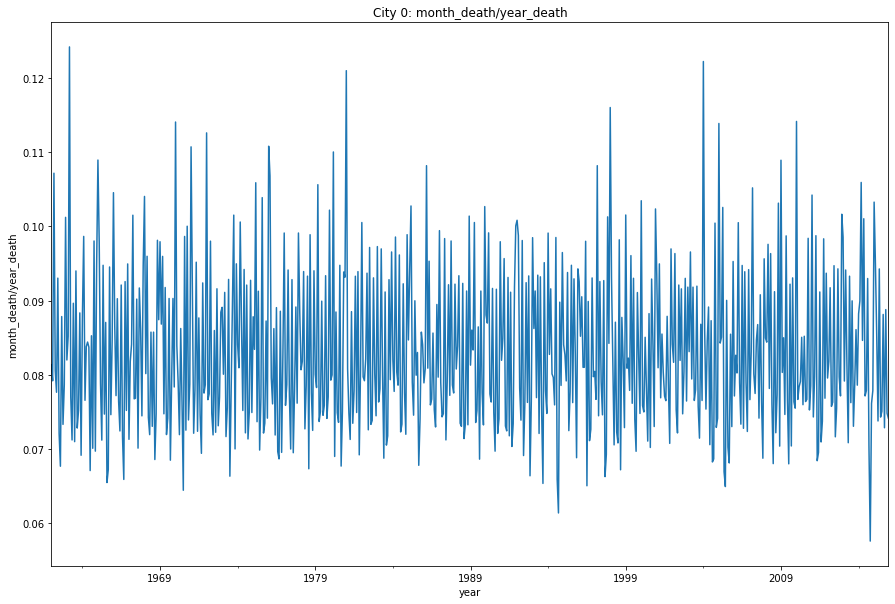

In [251]:
df_list_two[0]['month/year'].plot()
plt.title('City 0: month_death/year_death')
plt.xlabel('year')
plt.ylabel('month_death/year_death')
plt.show()

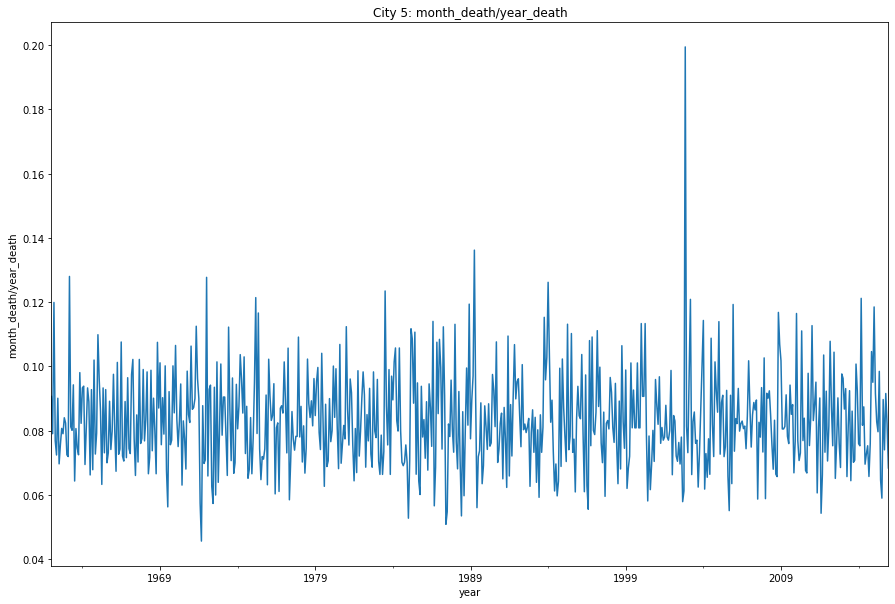

In [252]:
df_list_two[5]['month/year'].plot()
plt.title('City 5: month_death/year_death')
plt.xlabel('year')
plt.ylabel('month_death/year_death')
plt.show()

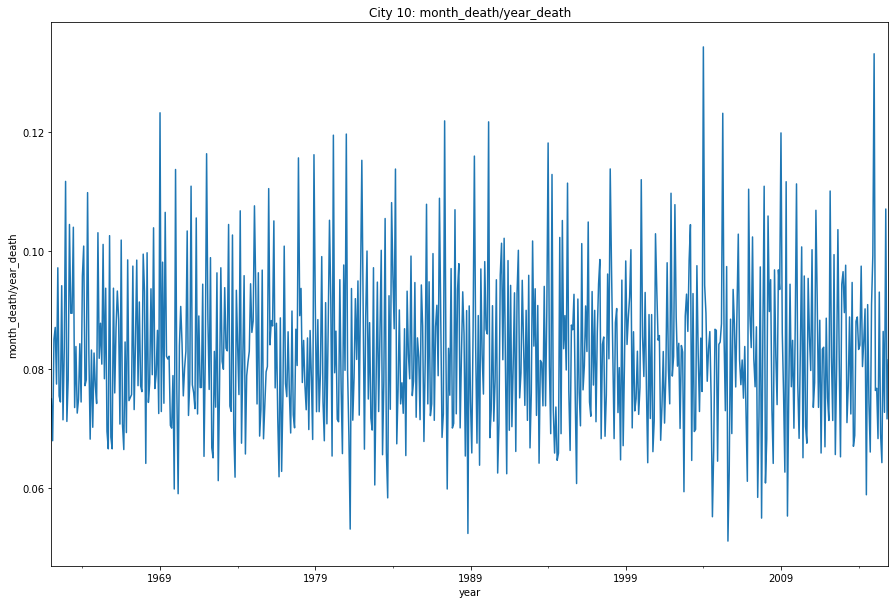

In [253]:
df_list_two[10]['month/year'].plot()
plt.title('City 10: month_death/year_death')
plt.xlabel('year')
plt.ylabel('month_death/year_death')
plt.show()

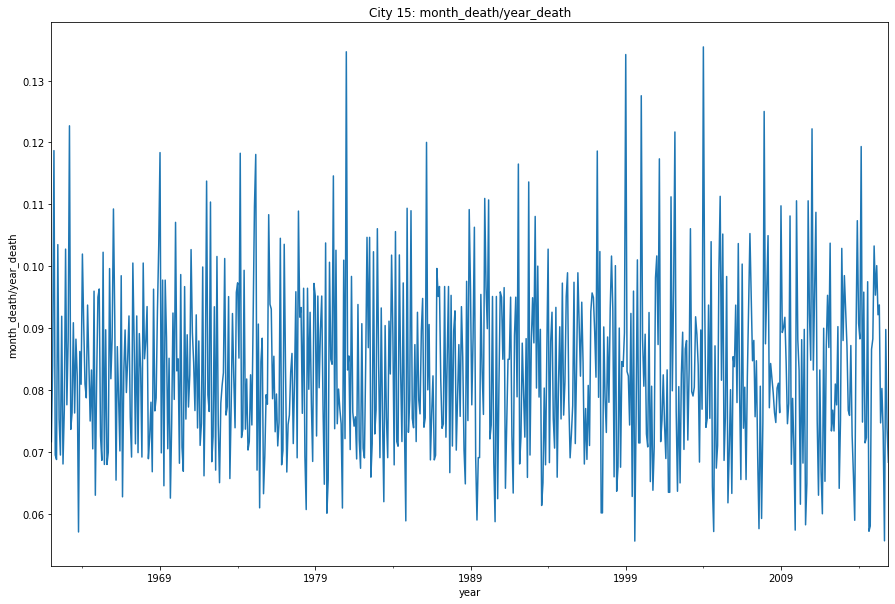

In [254]:
df_list_two[15]['month/year'].plot()
plt.title('City 15: month_death/year_death')
plt.xlabel('year')
plt.ylabel('month_death/year_death')
plt.show()

#### Outliers

As can be seen most clearly in the plot of 'City 5', outliers are present in the data.  Because this analysis is looking to model the normal or most common behavior of this phenomona, extream outliers should be eliminated.  We are already seeking to make predictions 5 years out from the data set, we do not want any recent extreme results to contaminate our results. 

We will replace outlier points with the mean of their respective cities

In [266]:
for X in df_list_two:
    x_bar=X['month/year'].mean()
    s=X['month/year'].std()
    upper_bound, lower_bound = x_bar + 3*s,x_bar - 3*s
    X.loc[X['month/year']>upper_bound,'month/year']= X['month/year'].mean()
    X.loc[X['month/year']<lower_bound,'month/year']= X['month/year'].mean()

#### Test for Stationarity

In [278]:
#This loop will notify when cities have a p-value greater than .001:
from statsmodels.tsa.stattools import adfuller
p_value_list=[]
for i in range(len(df_list_two)):
    X = df_list_two[i]['month/year'].values
    result = adfuller(X)
    if result[1] > .001:
        p_value_list.append((int(i),result[1]))
print(p_value_list)        

[]


It is safe to assume that the time series for each city is stationary.

## Modeling 